In [1]:
import tensorflow as tf
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from net.refinenet import RefineNet
%matplotlib inline

inp = tf.placeholder(tf.float32,shape=[None,224,224,4],name='input')
refine_net = RefineNet(inp,'resnet_v1_50','exp/coarse-weighted-f5-5/iters-14000')

net,end_points = refine_net.net,refine_net.end_points
coarse_net_end = end_points['tail/linear2']

# Attach sigmoid and reshape
coarse_out= tf.reshape(tf.sigmoid(coarse_net_end),[-1,56,56,1])
refine_out = tf.sigmoid(net)

sess = tf.InteractiveSession()
refine_net.initialize(sess,'exp/r-coarse-weighted-f5-5-4/iters-6000')
#saver = tf.train.Saver()
#saver.restore(sess, 'exp/test3/iters-20929')

print("Model Loaded")

INFO:tensorflow:Scale of 0 disables regularizer.


2016-10-20 12:51:22,276 - tensorflow - INFO - Scale of 0 disables regularizer.
Model Loaded


In [2]:
from dataprovider.preprocess import vgg_preprocess
import os
from skimage import transform
from dataprovider.davis import DataAccessHelper
import numpy as np
BASE_DIR = os.path.join('/work/george','DAVIS')
IMAGESETS = os.path.join('ImageSets','480p')
    
RESIZE_HEIGHT = 224
RESIZE_WIDTH = 224
helper = DataAccessHelper()
def read_image(imageFile,prevMask):
               
    # Read images 
    rgb = helper.read_image(imageFile,[RESIZE_HEIGHT,RESIZE_WIDTH])
    mask = prevMask
    print(mask.shape)
    mask = np.expand_dims(mask,axis=2)
        
    # Concatenate images
    image =  np.concatenate((rgb, mask), 2)
    
       
    #io.imshow(image[:,:,0:3])  
    #print('Max',image.max(),image.min())
    image = image*255
    #plt.imshow(image[:,:,0:3].astype(np.uint8)) 
    
    
    image = np.expand_dims(image,axis=0)
    
    image = vgg_preprocess(image)
    
    return image


2016-10-20 12:51:40,432 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2016-10-20 12:51:40,433 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 41 3945
(224, 224)
2016-10-20 12:51:42,646 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2016-10-20 12:51:42,647 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 41 3945
(224, 224)
2016-10-20 12:51:42,924 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2016-10-20 12:51:42,925 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 41 3708
(224, 224)
2016-10-20 12:51:43,233 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2016-10-20 12:51:43,234 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 41 3488
(224, 224)
2016-10-20 12:51:43,572 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2016-10-20 12:51:43,573 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 41 3382
(224, 224)
2016-10-20 12:51:43,847 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2016-10-20 12:51:43,847 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 41 3412
(224, 224)
2016-10-20

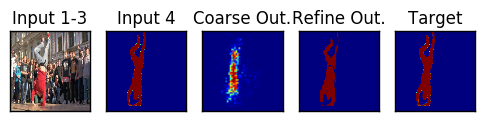

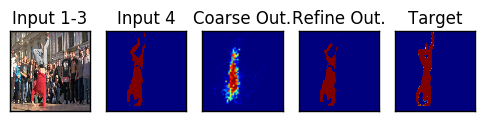

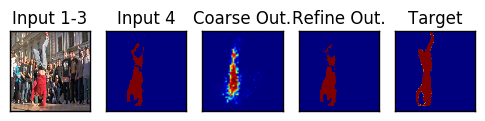

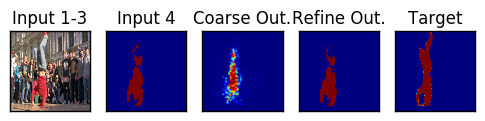

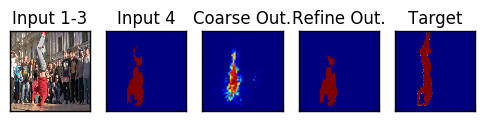

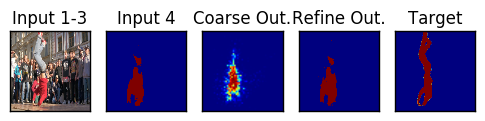

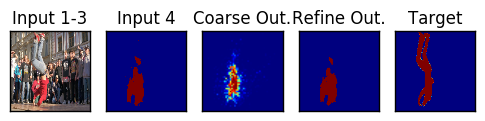

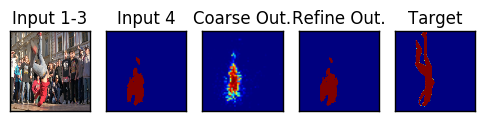

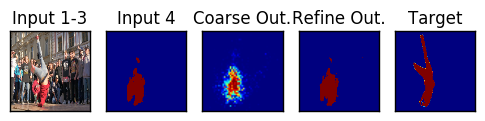

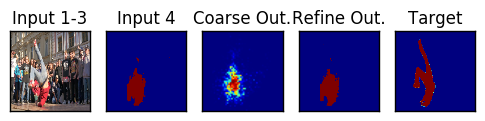

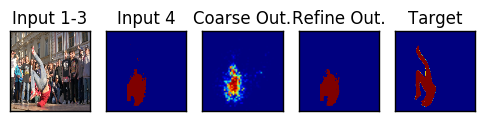

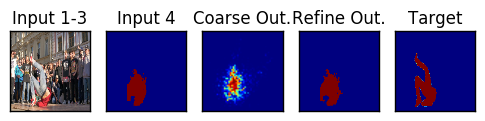

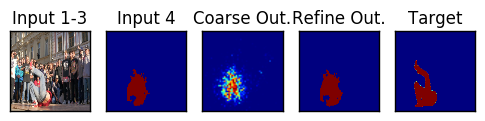

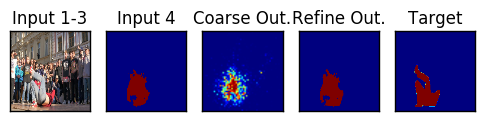

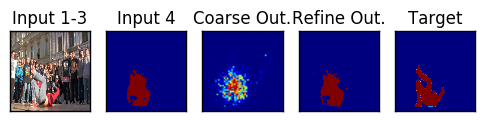

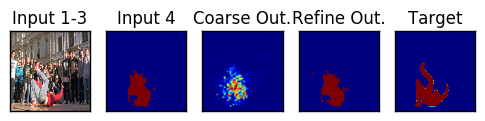

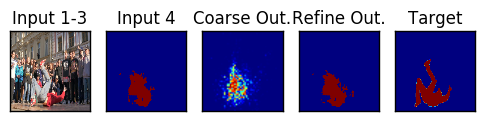

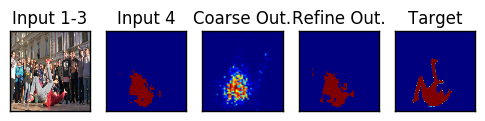

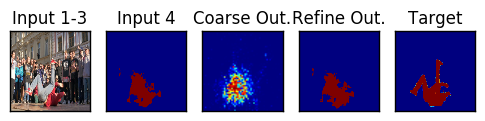

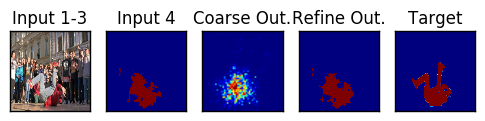

In [3]:
from skimage import morphology

from dataprovider.davis import DataAccessHelper
from test_refine_net import threshold_image

img_seq = 'breakdance'

start_frame= 0;
end_frame = 20;



_R_MEAN = 123.68
_G_MEAN = 116.78
_B_MEAN = 103.94
_M_MEAN = 127

start_frame_name = helper.image_path(img_seq,start_frame)
mask_file_name = helper.label_path(img_seq,start_frame)

prev_mask = helper.read_label(mask_file_name,[224,224])


for img_no in range(start_frame,end_frame):

    image_file =helper.image_path(img_seq,img_no)
   
    
    image = read_image(image_file,prev_mask)
    #image[0,:,:,3] = morphology.erosion(image[0,:,:,3],np.ones([3,3]))

    result = sess.run([coarse_out,refine_out],feed_dict={inp:image})

    plt.figure()


    #Plot input image
    plt.subplot(1,5,1)
    frame1 = plt.gca()
    frame1.axes.set_title('Input 1-3')
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    rgb = image[0,:,:,0:3]
    #print(rgb.shape)
    means = [_R_MEAN, _G_MEAN ,_B_MEAN]
    rgb = rgb + means
    plt.imshow(rgb.astype(np.uint8))

    #Plot previous label
    plt.subplot(1,5,2)
    
    frame1 = plt.gca()
    frame1.axes.set_title('Input 4')
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    plt.imshow(image[0,:,:,3])

    #Plot output
    plt.subplot(1,5,3)
    frame1 = plt.gca()
    frame1.axes.set_title('Coarse Out.')
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    plt.imshow(result[0][0,:,:,0])
    
    #Plot output
    plt.subplot(1,5,4)
    frame1 = plt.gca()
    frame1.axes.set_title('Refine Out.')
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    
    # Set previous mask
    prev_mask = threshold_image(result[1][0,:,:,0])
    plt.imshow(prev_mask)
    
    #Plot label
    label_path = helper.construct_label_path(image_file)
    label_img = helper.read_label(label_path,[224,224])
    plt.subplot(1,5,5)
    frame1 = plt.gca()
    frame1.axes.set_title('Target')
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    plt.imshow(label_img)

2016-10-20 13:06:15,750 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2016-10-20 13:06:15,751 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 41 3945
(224, 224)
2016-10-20 13:06:16,014 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2016-10-20 13:06:16,014 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 41 3708
(224, 224)
2016-10-20 13:06:16,603 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2016-10-20 13:06:16,605 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 41 3708
(224, 224)
2016-10-20 13:06:16,905 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2016-10-20 13:06:16,906 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 41 3708
(224, 224)
2016-10-20 13:06:17,221 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2016-10-20 13:06:17,221 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 41 3708
(224, 224)
2016-10-20 13:06:17,560 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2016-10-20 13:06:17,561 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 41 3708
(224, 224)
2016-10-20

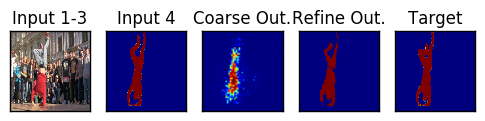

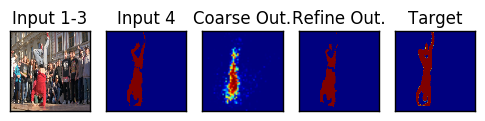

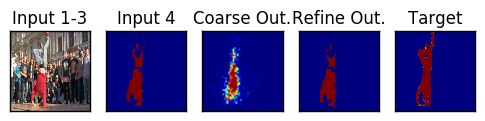

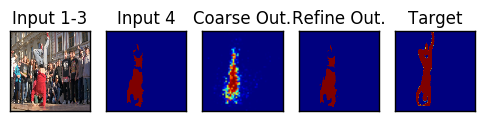

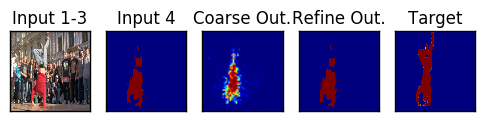

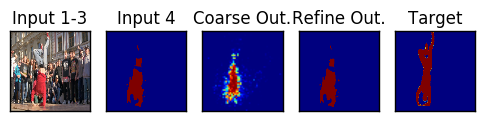

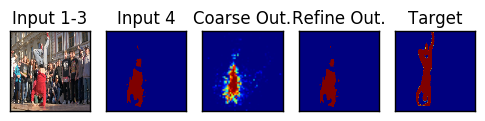

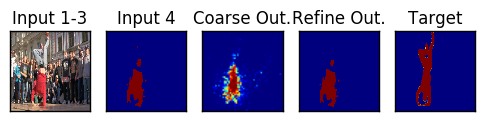

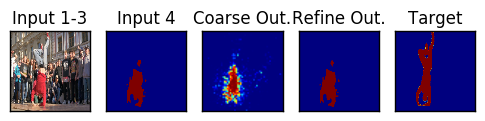

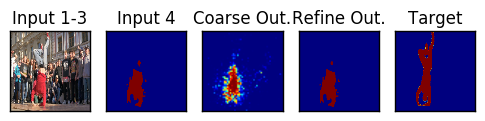

In [4]:
from dataprovider.davis import DataAccessHelper
from test_refine_net import threshold_image

img_seq = 'breakdance'
img_no = 1
_R_MEAN = 123.68
_G_MEAN = 116.78
_B_MEAN = 103.94
_M_MEAN = 127

start_frame_name = helper.image_path(img_seq,start_frame)
mask_file_name = helper.label_path(img_seq,img_no -1)

prev_mask = helper.read_label(mask_file_name,[224,224])

iterations = 10

for i in range(iterations):

    image_file =helper.image_path(img_seq,img_no)
   
    
    image = read_image(image_file,prev_mask)
    #image[0,:,:,3] = morphology.erosion(image[0,:,:,3],np.ones([3,3]))

    result = sess.run([coarse_out,refine_out],feed_dict={inp:image})

    plt.figure()


    #Plot input image
    plt.subplot(1,5,1)
    frame1 = plt.gca()
    frame1.axes.set_title('Input 1-3')
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    rgb = image[0,:,:,0:3]
    #print(rgb.shape)
    means = [_R_MEAN, _G_MEAN ,_B_MEAN]
    rgb = rgb + means
    plt.imshow(rgb.astype(np.uint8))

    #Plot previous label
    plt.subplot(1,5,2)
    
    frame1 = plt.gca()
    frame1.axes.set_title('Input 4')
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    plt.imshow(image[0,:,:,3])

    #Plot output
    plt.subplot(1,5,3)
    frame1 = plt.gca()
    frame1.axes.set_title('Coarse Out.')
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    plt.imshow(result[0][0,:,:,0])
    
    #Plot output
    plt.subplot(1,5,4)
    frame1 = plt.gca()
    frame1.axes.set_title('Refine Out.')
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    
    # Set previous mask
    prev_mask = threshold_image(result[1][0,:,:,0])
    plt.imshow(prev_mask)
    
    #Plot label
    label_path = helper.construct_label_path(image_file)
    label_img = helper.read_label(label_path,[224,224])
    plt.subplot(1,5,5)
    frame1 = plt.gca()
    frame1.axes.set_title('Target')
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)
    plt.imshow(label_img)